In [1]:
import pandas as pd
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
frame_test = pd.read_csv("hq_markup_train.csv")
frame_test.fillna(-2, inplace=True)
# frame_test["Граница постоянного давления_details"] = np.log10(frame_test["Граница постоянного давления_details"])
# frame_test["Граница непроницаемый разлом_details"] = np.log10(frame_test["Граница непроницаемый разлом_details"])
# frame_test.fillna(-0.5, inplace=True)
frame = pd.read_csv("markup_train.csv")
frame.fillna(-2, inplace=True)

def get_sample(index, frame):
    uuid = frame.iloc[index, 0]
    with open(f'data/{uuid}', 'r') as f:
        content = f.read()
    rows = [line.split('\t') for line in content.strip().split('\n')]
    data = pd.DataFrame(rows, columns=['time', 'delta_p', 'p_'], dtype=float)
    return data


def find_empty_indexes_2(data):
    """
    Поиск id файлов из строк датафрейма для их исключения на этапе удаления данных из датафрейма
    """
    B=[]
    for i in range(data.shape[0]):
        try:
            df=get_sample(i,data)
        except ValueError:
            B.append(data.iloc[i,0])
    return B


class SiamDataset(Dataset):
    def __init__(self, siam_dataset_describe:pd.DataFrame):
        super().__init__()
        self.siam_dataset_describe = siam_dataset_describe

    def __len__(self):
        return self.siam_dataset_describe.shape[0]

    def __getitem__(self, idx):
        x = get_sample(idx, self.siam_dataset_describe) #.to_numpy(dtype=np.float64)
        x = x[["time", "delta_p", "p_"]].to_numpy(dtype=np.float64)
        


# #         # 7) Возвращаем (X, Y)                                                  # Давление(атм) ([:, 1]) Давление(атм) ([:,1]) Давление(атм) ([:,1]) Давление(атм) ([:,1]) Давление(атм) ([:,1]) В какой момент? [:, 0]   В какой момент? [:, 0]
# #         return x, self.siam_dataset_describe.iloc[idx][['Влияние ствола скважины_details', 'Радиальный режим_details', 'Линейный режим_details', 'Билинейный режим_details', 'Сферический режим_details', 'Граница постоянного давления_details', 'Граница непроницаемый разлом_details']].to_numpy(dtype=np.float32)

# B=find_empty_indexes_2(frame)#Поиск id с отсутствующими файлами для исключения
# frame=frame[~frame['file_name'].isin(B)]#Фильтрация данных
# # frame = frame[~frame["file_name"].isin(frame_test["file_name"])]

In [4]:
frame_test.head(10)

,file_name,department_name,user_name,Некачественное ГДИС,Влияние ствола скважины,Радиальный режим,Линейный режим,Билинейный режим,Сферический режим,Граница постоянного давления,Граница непроницаемый разлом,Влияние ствола скважины_details,Радиальный режим_details,Линейный режим_details,Билинейный режим_details,Сферический режим_details,Граница постоянного давления_details,Граница непроницаемый разлом_details
0,e9c7e07f-b723-4da3-918e-7dbcb360c830,department2,user5,0,1,1,0,0,0,0,1,2.082030,0.109087,-2.000000,-2.000000,-2.0,-2.000000,4.647373
1,726565c9-e05b-4a28-9079-22d94f9bb9e2,department3,user4,0,1,1,1,0,0,0,0,2.714919,1.220888,1.353544,-2.000000,-2.0,-2.000000,-2.000000
2,c2a4d43d-5a93-4c37-81b6-d4fdc5b0280b,department3,user5,1,0,0,0,0,0,0,0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000
3,15e04219-9fa0-401d-8b42-833b71ccafb3,department3,user5,0,1,1,0,0,0,0,0,1.909838,1.569424,-2.000000,-2.000000,-2.0,-2.000000,-2.000000
4,d43f459d-97fa-4ab0-bacc-43e2cb73e1b9,department1,user1,0,1,1,1,0,0,0,0,1.298287,1.140658,0.387881,-2.000000,-2.0,-2.000000,-2.000000
5,02280dfe-62b6-4595-904c-2c47cc034656,department3,user2,1,0,0,0,0,0,0,0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000
6,96780ecb-78c8-450c-ac83-8263b8e0a4f6,department1,user5,0,0,1,0,1,0,0,0,-2.000000,1.106105,-2.000000,1.515715,-2.0,-2.000000,-2.000000
7,65482016-39dd-45b9-8c9d-f602ab64eaed,department3,user2,0,1,1,0,1,0,1,0,1.750161,1.090070,-2.000000,0.966248,-2.0,62.885563,-2.000000
8,26cdb41a-0d92-4db0-b307-d0128c758701,department3,user2,1,0,0,0,0,0,0,0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000
9,7dd02ac2-752f-4903-911f-1da319608a3e,department3,user5,1,0,0,0,0,0,0,0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,-2.000000


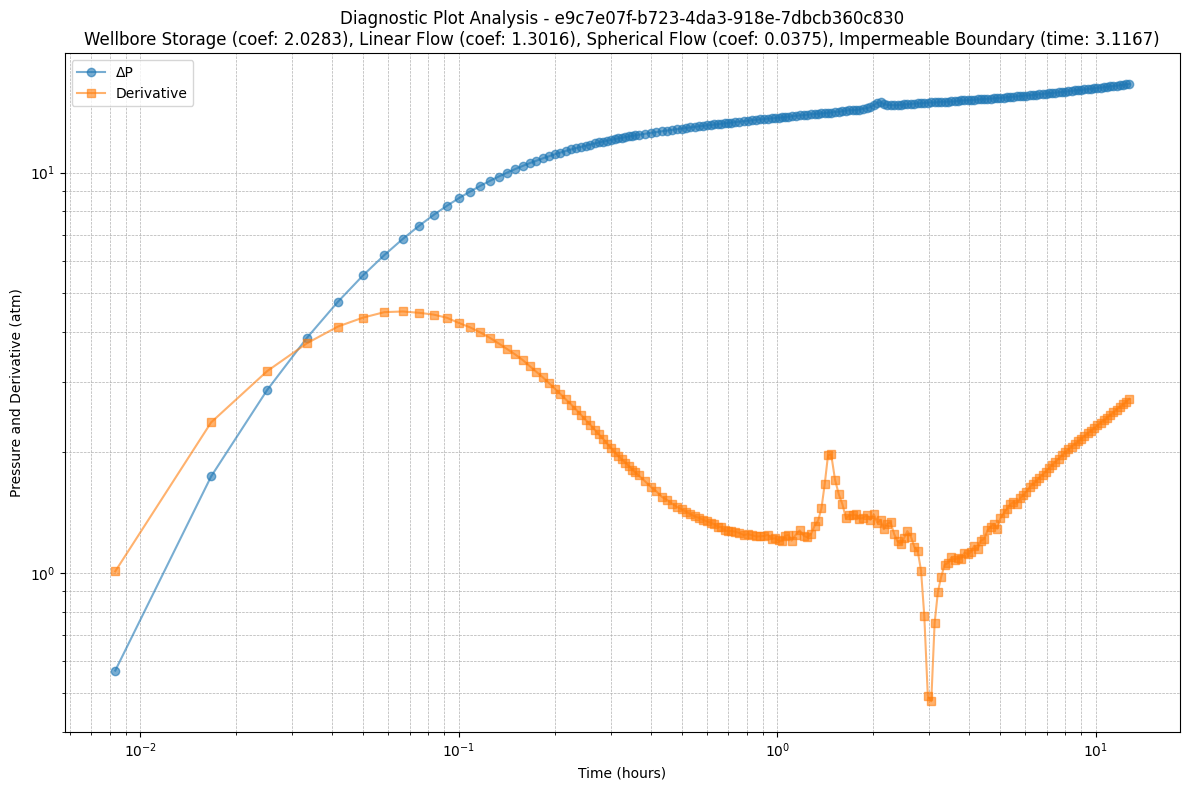

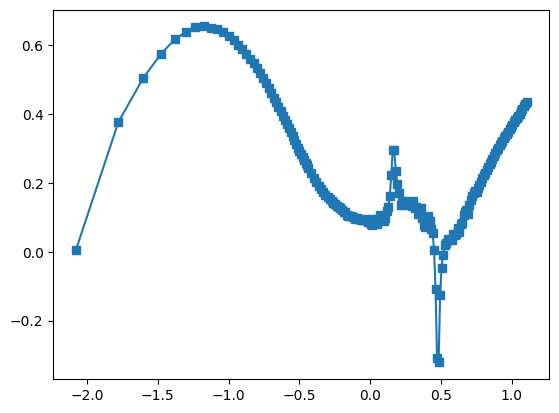

In [21]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import logging
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class DiagnosticPlotAnalyzer:
    """
    A class to analyze diagnostic plots from oil and gas wells
    and identify specific flow patterns and their characteristics.
    """
    
    def __init__(self):
        # Pattern slopes for different flow regimes
        self.pattern_slopes = {
            'wb': 1.0,      # Wellbore storage: slope = 1
            'ra': 0.0,      # Radial flow: slope = 0
            'li': 0.5,      # Linear flow: slope = 0.5
            'bi': 0.25,     # Bilinear flow: slope = 0.25
            'sp': -0.5,     # Spherical flow: slope = -0.5
        }
        
        # Minimum number of points required for a pattern
        self.min_points = 2
        
        # Minimum log cycle span required for reliable identification
        self.min_log_cycle = 0.5
        
        # Tolerance for slope matching
        self.slope_tolerance = 0.1
        
        # Window size for moving average smoothing (in points)
        self.window_size = 5
        
        # Minimum R² for linear regression to be considered valid
        self.min_r2 = 0.9
        
        # Noise threshold for bad quality detection
        self.noise_threshold = 0.3
        
    def read_data(self, file_path):
        """Read the data from a file and return time, pressure, and derivative"""
        try:
            uuid = file_path
            with open(f'data/{uuid}', 'r') as f:
                content = f.read()
            rows = [line.split('\t') for line in content.strip().split('\n')]
            data = pd.DataFrame(rows, columns=['time', 'delta_p', 'p_'], dtype=float)
            time = data["time"].to_numpy()       # Time (hours)
            delta_p = data["delta_p"].to_numpy()      # Delta pressure (atm)
            derivative = data["p_"].to_numpy()   # Derivative (atm)
            
            return time, delta_p, derivative
        except Exception as e:
            logger.error(f"Error reading file {file_path}: {e}")
            return None, None, None
    
    def smooth_data(self, data, window_size=None):
        """Apply moving average smoothing to the data"""
        if window_size is None:
            window_size = self.window_size
            
        if len(data) < window_size:
            return data
            
        smoothed = np.zeros_like(data)
        half_window = window_size // 2
        
        # Handle boundary conditions
        smoothed[:half_window] = data[:half_window]
        smoothed[-half_window:] = data[-half_window:]
        
        # Apply moving average
        for i in range(half_window, len(data) - half_window):
            smoothed[i] = np.mean(data[i-half_window:i+half_window+1])
            
        return smoothed
    
    def calculate_log_time(self, time):
        """Calculate log of time for log-log plots"""
        return np.log10(time)
    
    def calculate_log_pressure(self, pressure):
        """Calculate log of pressure for log-log plots"""
        # Ensure all pressure values are positive
        min_positive = np.min(pressure[pressure > 0]) / 10 if any(pressure > 0) else 1e-10
        adjusted_pressure = np.maximum(pressure, min_positive)
        return np.log10(adjusted_pressure)
    
    def detect_bad_quality(self, time, delta_p, derivative):
        """
        Detect if the data is of bad quality (bq)
        
        Returns:
            bool: True if data is bad quality, False otherwise
        """
        # Check for NaN or Inf values
        if np.isnan(delta_p).any() or np.isinf(delta_p).any() or \
           np.isnan(derivative).any() or np.isinf(derivative).any():
            return True
            
        # Check for large gaps in time data
        log_time = self.calculate_log_time(time)
        time_diff = np.diff(log_time)
        if np.max(time_diff) > 0.5:  # Check for gaps larger than half a log cycle
            return True
            
        # Check for noise in derivative data
        log_derivative = self.calculate_log_pressure(derivative)
        derivative_smoothed = self.smooth_data(log_derivative)
        noise = np.std(log_derivative - derivative_smoothed)
        if noise > self.noise_threshold:
            return True
            
        # Check for sudden large jumps in pressure
        log_delta_p = self.calculate_log_pressure(delta_p)
        pressure_smoothed = self.smooth_data(log_delta_p)
        jumps = np.abs(log_delta_p - pressure_smoothed)
        if np.max(jumps) > 0.5:  # Check for jumps larger than half a log unit
            return True
            
        # Check if the first few points are consistent
        if len(time) > 5:
            initial_slope = np.polyfit(log_time[:5], log_delta_p[:5], 1)[0]
            if abs(initial_slope) > 2:  # Unusually steep initial slope
                return True
                
        return False
    
    def fit_line_segment(self, x, y, start_idx, end_idx):
        """
        Fit a line segment to the data between start_idx and end_idx
        
        Returns:
            slope: Slope of the line
            intercept: Y-intercept of the line
            r2: R-squared value of the fit
        """
        if end_idx - start_idx < self.min_points:
            return None, None, 0
            
        x_segment = x[start_idx:end_idx]
        y_segment = y[start_idx:end_idx]
        
        # Check if segment spans enough log cycles
        if max(x_segment) - min(x_segment) < self.min_log_cycle:
            return None, None, 0
            
        # Perform linear regression
        model = LinearRegression()
        X = x_segment.reshape(-1, 1)
        model.fit(X, y_segment)
        
        slope = model.coef_[0]
        intercept = model.intercept_
        
        # Calculate R²
        y_pred = model.predict(X)
        ss_total = np.sum((y_segment - np.mean(y_segment))**2)
        ss_residual = np.sum((y_segment - y_pred)**2)
        r2 = 1 - (ss_residual / ss_total) if ss_total > 0 else 0
        
        return slope, intercept, r2
    
    def detect_flow_pattern(self, log_time, log_derivative, pattern, min_segment_points=1):
        """
        Detect a specific flow pattern based on the derivative slope
        
        Args:
            log_time: Log of time values
            log_derivative: Log of derivative values
            pattern: Pattern to detect ('wb', 'ra', 'li', 'bi', 'sp')
            
        Returns:
            detected: True if pattern is detected, False otherwise
            intercept: Y-intercept of the fitted line (or None if not detected)
        """
        target_slope = self.pattern_slopes[pattern]
        best_r2 = 0
        best_intercept = None
        best_segment = None
        
        # Try different segment lengths
        for start_idx in range(len(log_time) - min_segment_points):
            for end_idx in range(start_idx + min_segment_points, len(log_time) + 1):
                slope, intercept, r2 = self.fit_line_segment(log_time, log_derivative, start_idx, end_idx)
                
                if slope is None:
                    continue
                    
                # Check if slope matches target slope within tolerance
                if abs(slope - target_slope) <= self.slope_tolerance and r2 > best_r2:
                    best_r2 = r2
                    best_intercept = intercept
                    best_segment = (start_idx, end_idx)
        
        # Determine if pattern is detected based on fit quality
        detected = best_r2 > self.min_r2
        
        # For wellbore storage (wb), check if it appears at the beginning
        if pattern == 'wb' and detected:
            start_idx, _ = best_segment
            detected = start_idx < len(log_time) // 2  # Must be in first quarter
        
        # For radial flow (ra), the segment must be substantial
        if pattern == 'ra' and detected:
            start_idx, end_idx = best_segment
            span = log_time[end_idx-1] - log_time[start_idx]
            detected = span >= self.min_log_cycle and best_r2 > 0.8
        
        return detected, best_intercept
    
    def detect_boundary_effects(self, log_time, log_derivative, time):
        """
        Detect boundary effects: constant pressure (pc) or impermeable (im)
        
        Returns:
            pc_detected: True if constant pressure boundary detected
            pc_time: Time at which boundary effect starts (or None)
            im_detected: True if impermeable boundary detected
            im_time: Time at which boundary effect starts (or None)
        """
        # Calculate derivative trends at the end of the test
        n = len(log_time)
        if n < 10:
            return False, None, False, None
            
        # Look at the last third of the data
        last_third_start = max(0, int(n * 2/3))
        end_trend = np.polyfit(log_time[last_third_start:], log_derivative[last_third_start:], 1)[0]
        
        # Constant pressure boundary (pc) - derivative decreases at the end
        pc_detected = end_trend < -0.2
        pc_time = None
        
        # Impermeable boundary (im) - derivative increases at the end
        im_detected = end_trend > 0.3 and end_trend <= 1.2
        im_time = None
        
        # Find where the effect starts
        if pc_detected or im_detected:
            # Find the inflection point or significant change
            derivative_diff = np.diff(log_derivative[last_third_start:])
            
            # Look for significant changes
            if pc_detected:
                # Find where derivative starts consistently decreasing
                neg_diffs = derivative_diff < -0.05
                if any(neg_diffs):
                    change_idx = np.where(neg_diffs)[0][0] + last_third_start
                    pc_time = time[change_idx]
            
            if im_detected:
                # Find where derivative starts consistently increasing
                pos_diffs = derivative_diff > 0.05
                if any(pos_diffs):
                    change_idx = np.where(pos_diffs)[0][0] + last_third_start
                    im_time = time[change_idx]
        
        return pc_detected, pc_time, im_detected, im_time
    
    def analyze_file(self, file_path):
        """
        Analyze a single file and identify patterns
        
        Returns:
            dict: Dictionary with pattern flags and their characteristics
        """
        # Read the data
        time, delta_p, derivative = self.read_data(file_path)
        if time is None:
            logger.error(f"Failed to read data from {file_path}")
            return self._create_empty_result()
            
        # Ensure all values are positive for logarithm
        time = np.maximum(time, 1e-10)
        delta_p = np.maximum(delta_p, 1e-10)
        derivative = np.maximum(derivative, 1e-10)
        
        # Calculate logarithmic values for analysis
        log_time = self.calculate_log_time(time)
        log_delta_p = self.calculate_log_pressure(delta_p)
        log_derivative = self.calculate_log_pressure(derivative)
        
        # Apply smoothing
        log_derivative_smooth = log_derivative# self.smooth_data(log_derivative)
        
        # Initialize results dictionary
        result = {
            'file': os.path.basename(file_path),
            'bq': 0,  # Bad quality
            'wb': 0,  # Wellbore storage
            'ra': 0,  # Radial flow
            'li': 0,  # Linear flow
            'bi': 0,  # Bilinear flow
            'sp': 0,  # Spherical flow
            'pc': 0,  # Constant pressure boundary
            'im': 0,  # Impermeable boundary
            'wb_d': None,
            'ra_d': None,
            'li_d': None,
            'bi_d': None,
            'sp_d': None,
            'pc_d': None,
            'im_d': None
        }
        
        # Check data quality
        result['bq'] = 1 if self.detect_bad_quality(time, delta_p, derivative) else 0
        
        # Detect flow patterns
        # Wellbore storage (wb)
        wb_detected, wb_intercept = self.detect_flow_pattern(log_time, log_derivative_smooth, 'wb')
        result['wb'] = 1 if wb_detected else 0
        if wb_detected:
            # Convert intercept to coefficient
            result['wb_d'] = wb_intercept #10**wb_intercept
        
        # Radial flow (ra)
        ra_detected, ra_intercept = self.detect_flow_pattern(log_time, log_derivative_smooth, 'ra')
        result['ra'] = 1 if ra_detected else 0
        if ra_detected:
            # Convert intercept to coefficient
            result['ra_d'] = ra_intercept # 10**ra_intercept
        
        # Linear flow (li)
        li_detected, li_intercept = self.detect_flow_pattern(log_time, log_derivative_smooth, 'li')
        result['li'] = 1 if li_detected else 0
        if li_detected:
            # Convert intercept to coefficient
            result['li_d'] = li_intercept #10**li_intercept
        
        # Bilinear flow (bi)
        bi_detected, bi_intercept = self.detect_flow_pattern(log_time, log_derivative_smooth, 'bi')
        result['bi'] = 1 if bi_detected else 0
        if bi_detected:
            # Convert intercept to coefficient
            result['bi_d'] = bi_intercept# 10**bi_intercept
        
        # Spherical flow (sp)
        sp_detected, sp_intercept = self.detect_flow_pattern(log_time, log_derivative_smooth, 'sp')
        result['sp'] = 1 if sp_detected else 0
        if sp_detected:
            # Convert intercept to coefficient
            result['sp_d'] = sp_intercept# 10**sp_intercept
        
        # Detect boundary effects
        pc_detected, pc_time, im_detected, im_time = self.detect_boundary_effects(
            log_time, log_derivative_smooth, time
        )
        
        result['pc'] = 1 if pc_detected else 0
        if pc_detected and pc_time is not None:
            result['pc_d'] = pc_time
            
        result['im'] = 1 if im_detected else 0
        if im_detected and im_time is not None:
            result['im_d'] = im_time
        
        return result
    
    def _create_empty_result(self):
        """Create an empty result dictionary when analysis fails"""
        return {
            'file': '',
            'bq': 0, 'wb': 0, 'ra': 0, 'li': 0, 'bi': 0, 'sp': 0, 'pc': 0, 'im': 0,
            'wb_d': None, 'ra_d': None, 'li_d': None, 'bi_d': None, 
            'sp_d': None, 'pc_d': None, 'im_d': None
        }
    
    def visualize_analysis(self, file_path, result=None):
        """
        Visualize the analysis results
        
        Args:
            file_path: Path to the data file
            result: Analysis result dictionary (if None, perform analysis)
        """
        if result is None:
            result = self.analyze_file(file_path)
            
        # Read the data
        time, delta_p, derivative = self.read_data(file_path)
        if time is None:
            logger.error(f"Failed to read data from {file_path}")
            return
            
        # Calculate logarithmic values
        log_time = self.calculate_log_time(time)
        log_delta_p = self.calculate_log_pressure(delta_p)
        log_derivative = self.calculate_log_pressure(derivative)
        
        # Create the figure
        plt.figure(figsize=(12, 8))
        
        # Plot the data on a log-log scale
        plt.loglog(time, delta_p, 'o-', label='ΔP', alpha=0.6)
        plt.loglog(time, derivative, 's-', label='Derivative', alpha=0.6)
        
        # Add pattern information
        patterns = []
        if result['bq'] == 1:
            patterns.append("Bad Quality Data")
        if result['wb'] == 1:
            patterns.append(f"Wellbore Storage (coef: {result['wb_d']:.4f})")
        if result['ra'] == 1:
            patterns.append(f"Radial Flow (coef: {result['ra_d']:.4f})")
        if result['li'] == 1:
            patterns.append(f"Linear Flow (coef: {result['li_d']:.4f})")
        if result['bi'] == 1:
            patterns.append(f"Bilinear Flow (coef: {result['bi_d']:.4f})")
        if result['sp'] == 1:
            patterns.append(f"Spherical Flow (coef: {result['sp_d']:.4f})")
        if result['pc'] == 1:
            patterns.append(f"Constant Pressure Boundary (time: {result['pc_d']:.4f})")
        if result['im'] == 1:
            patterns.append(f"Impermeable Boundary (time: {result['im_d']:.4f})")
            
        # Set labels and title
        plt.xlabel('Time (hours)')
        plt.ylabel('Pressure and Derivative (atm)')
        plt.title(f"Diagnostic Plot Analysis - {os.path.basename(file_path)}\n{', '.join(patterns)}")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        
        # Show the plot
        plt.tight_layout()
        plt.show()

        plt.plot(log_time, log_derivative, 's-', label='Derivative')
        plt.show()

    def process_folder(self, folder_path, output_file=None):
        """
        Process all files in a folder and write results to a CSV file
        
        Args:
            folder_path: Path to folder containing data files
            output_file: Path to output CSV file (if None, use default name)
            
        Returns:
            DataFrame: Results dataframe
        """
        if output_file is None:
            output_file = os.path.join(folder_path, 'analysis_results.csv')
            
        # Get all files in the folder
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        
        # Initialize results list
        results = []
        
        # Process each file
        total_files = len(files)
        for i, file in enumerate(files):
            if i % 100 == 0:
                logger.info(f"Processing file {i+1}/{total_files}: {file}")
                
            file_path = os.path.join(folder_path, file)
            result = self.analyze_file(file_path)
            result['file'] = file  # Use just the filename, not the full path
            results.append(result)
            
        # Convert to DataFrame
        df_results = pd.DataFrame(results)
        
        # Reorder columns to match the expected format
        columns = ['file', 'bq', 'wb', 'ra', 'li', 'bi', 'sp', 'pc', 'im',
                  'wb_d', 'ra_d', 'li_d', 'bi_d', 'sp_d', 'pc_d', 'im_d']
        df_results = df_results[columns]
        
        # Write to CSV
        df_results.to_csv(output_file, index=False)
        logger.info(f"Results saved to {output_file}")
        
        return df_results

# Example usage
if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = DiagnosticPlotAnalyzer()
    
    # Set the data folder path
    data_folder = "./data"
    
    # # Process all files in the folder
    # results_df = analyzer.process_folder(data_folder)
    
    # Example: Visualize a specific file
    # sample_file = os.path.join(data_folder, "sample_file")
    analyzer.visualize_analysis("e9c7e07f-b723-4da3-918e-7dbcb360c830")
    
    # print(f"Analysis complete. Processed {len(results_df)} files.")

In [6]:
frame_test.head(1)

,file_name,department_name,user_name,Некачественное ГДИС,Влияние ствола скважины,Радиальный режим,Линейный режим,Билинейный режим,Сферический режим,Граница постоянного давления,Граница непроницаемый разлом,Влияние ствола скважины_details,Радиальный режим_details,Линейный режим_details,Билинейный режим_details,Сферический режим_details,Граница постоянного давления_details,Граница непроницаемый разлом_details
0,e9c7e07f-b723-4da3-918e-7dbcb360c830,department2,user5,0,1,1,0,0,0,0,1,2.08203,0.109087,-2.0,-2.0,-2.0,-2.0,4.647373
